In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Effective magnetic field plots (Morales-Durán et al.)

Goal: follow the computations in the paper and, using the same symbols, plot the relevant parameters of the bilayer Hamiltonian and the effective magnetic field obtained from it.

Paper https://arxiv.org/pdf/2308.03143.pdf

In [39]:
class twistedTMB:

    def __init__(self, modelParameters_, N, xMax):
        
        self.Vm, self.psi, self.w, self.aM = modelParameters_
        self.N = N
        self.xMax = abs(xMax)

        self.k_theta = (4 * np.pi) / (self.aM * np.sqrt(3))
        self.G1, self.G2, self.G3, self.G4, self.G5, self.G6 = [self.k_theta * np.array([np.cos(np.pi * i/3), np.sin(np.pi * i/3)]) for i in range(1,7)]
        self.q1 = self.k_theta * np.array([0, -1 / np.sqrt(3)])
        self.q2 = self.G2 + self.q1
        self.q3 = self.G3 + self.q1

        self.xArray = np.linspace(-self.xMax, self.xMax, self.N, endpoint=True)
        self.yArray = np.linspace(-self.xMax, self.xMax, self.N, endpoint=True)
        self.xx, self.yy = np.meshgrid(self.xArray, self.yArray)

        self.fieldsDict = {}

    # interlayer potentials
    def TMB_potential(self):
        
        # Layer potentials \Delta_b, \Delta_t, complex tunnelling potential \Delta_T
        self.Del_b = np.zeros((self.N,self.N))
        self.Del_t = np.zeros((self.N,self.N))
        self.Del_T = np.zeros((self.N,self.N), dtype='complex128')
        for i in range(self.N):
                for j in range(self.N):
                    r = np.array([self.xx[i,j], self.yy[i,j]])
                    self.Del_b[i,j] = 2 * self.Vm * (np.cos(np.vdot(self.G1, r) + self.psi) +
                                                     np.cos(np.vdot(self.G3, r) + self.psi) +
                                                     np.cos(np.vdot(self.G5, r) + self.psi))
                    self.Del_t[i,j] = 2 * self.Vm * (np.cos(np.vdot(self.G1, r) - self.psi) +
                                                     np.cos(np.vdot(self.G3, r) - self.psi) +
                                                     np.cos(np.vdot(self.G5, r) - self.psi))
                    self.Del_T[i,j] = self.w *  (np.exp(1j * np.vdot(self.q1, r)) +
                                                 np.exp(1j * np.vdot(self.q2, r)) +
                                                 np.exp(1j * np.vdot(self.q3, r)))
        
        # Pauli decomposition of the layer Hamiltonian, \Delta_0 and \mathbf{\Delta}
        self.Del_0 = (self.Del_b + self.Del_t) / 2
        self.Delta = np.array([np.real(self.Del_T), np.imag(self.Del_T), (self.Del_b - self.Del_t) / 2])

        # Normalisation of the Pauli vector \abs{\mathbf{\Delta}} and \mathbf{n}
        self.abs_Delta = np.linalg.norm(self.Delta,axis=0)
        self.n = self.Delta / self.abs_Delta

        self.Zeeman = self.abs_Delta + self.Del_0

        self.fieldsDict.update({
                                'Del_b': ['$\Delta_b$', self.Del_b],
                                'Del_t': ['$\Delta_t$', self.Del_t],
                                'Del_0': ['$\Delta_0$', self.Del_0],
                                'Delta[0]': ['$\Delta_1 = \mathrm{Re}(\Delta_T)$', self.Delta[0]],
                                'Delta[1]': ['$\Delta_2 = \mathrm{Im}(\Delta_T)$', self.Delta[1]],
                                'Delta[2]': ['$\Delta_3$', self.Delta[2]],
                                'abs_Delta': ['$|\Delta|$', self.abs_Delta],
                                'n[0]': ['$n_1 = \sin(\\theta) \cos(\phi)$', self.n[0]],
                                'n[1]': ['$n_2 = \sin(\\theta) \sin(\phi)$', self.n[1]],
                                'n[2]': ['$n_3 = \cos(\\theta)$', self.n[2]],
                                'Zeeman': ['$\\tilde{\Delta} = |\Delta| + \Delta_0$', self.Zeeman]
             })
    

    # Derivatives and effective magnetic field
    def effectiveB(self):
        
        # note with the way np.meshgrid works, x is the 2 direction and y is the 1
        self.n_x, self.n_y = np.gradient(self.n, 2 * self.xMax/(self.N - 1), axis=(2,1))
        
        self.B = np.zeros((self.N,self.N))
        for i in range(self.N):
            for j in range(self.N):
                self.B[i,j] = 0.5 * np.vdot(self.n[:,i,j], np.cross(self.n_x[:,i,j], self.n_y[:,i,j]))
        
        self.fieldsDict.update({'B': ['$B$ from $\mathbf{n}$', self.B]})
    
    # Hermitian traceless unitary to diagonalize bilayer interaction as 3-vector in Pauli basis
    def unitary(self):
        self.u = np.array([
                            self.Delta[0] / np.sqrt(2 * self.abs_Delta * (self.Delta[2] + self.abs_Delta)),
                            self.Delta[1] / np.sqrt(2 * self.abs_Delta * (self.Delta[2] + self.abs_Delta)),
                            np.sqrt((self.Delta[2] + self.abs_Delta) / (2 * self.abs_Delta))
        ])

        self.fieldsDict.update({
                                'u[0]': ['$u_1 = \sin(\\theta /2) \cos(\phi)$', self.u[0]],
                                'u[1]': ['$u_2 = \sin(\\theta /2) \sin(\phi)$', self.u[1]],
                                'u[2]': ['$u_3 = \cos(\\theta /2)$', self.u[2]]
        })

    # pseudospin matrix-valued gauge field from derivative acting on unitary, written in Pauli basis (zero term is total derivative)
    def gaugeMatrix(self):

        # derivatives of u
        self.u_x, self.u_y = np.gradient(self.u, 2 * self.xMax/(self.N - 1), axis=(2,1))

        # three components
        self.A1 = np.array([self.u[1]* self.u_x[2] - self.u[2] * self.u_x[1], self.u[1]* self.u_y[2] - self.u[2] * self.u_y[1]])
        self.A2 = np.array([self.u[2]* self.u_x[0] - self.u[0] * self.u_x[2], self.u[2]* self.u_y[0] - self.u[0] * self.u_y[2]])
        self.A3 = np.array([self.u[0]* self.u_x[1] - self.u[1] * self.u_x[0], self.u[0]* self.u_y[1] - self.u[1] * self.u_y[0]])

    def angles(self):

        # the angles
        self.theta = np.arccos(self.n[2])
        # \sin(\theta) always nonnegative on this domain
        self.cosPhi = self.n[0] / np.sin(self.theta)
        self.sinPhi = self.n[1] / np.sin(self.theta)
        self.tanPhi = self.n[1] / self.n[0]

        # because of the multivaluedness of the inverse function, need to obtain phi case by case
        self.phi = np.zeros((self.N,self.N))
        for i in range(self.N):
                for j in range(self.N):
                    # if \sin(\phi) positive, we are between zero and pi, so then arccos will get the correct angle
                    if self.sinPhi[i,j] >= 0:
                         self.phi[i,j] = np.arccos(self.cosPhi[i,j])
                    else:
                         self.phi[i,j] = 2 * np.pi - np.arccos(self.cosPhi[i,j])

        # alternative: phi in range [-\pi, \pi] rather than [0, 2 \pi]
        self.phi2 = np.zeros((self.N,self.N))
        for i in range(self.N):
                for j in range(self.N):
                    # if \sin(\phi) positive, we are between zero and pi, so then arccos will get the correct angle
                    if self.sinPhi[i,j] >= 0:
                         self.phi2[i,j] = np.arccos(self.cosPhi[i,j])
                    else:
                         self.phi2[i,j] = - np.arccos(self.cosPhi[i,j])
                         
        
        self.fieldsDict.update({'theta': ['$\\theta / \pi$', self.theta / np.pi],
                                'phi': ['$\phi / \pi$', self.phi / np.pi],
                                'phi2': ['$\phi / \pi$', self.phi2 / np.pi]
                                })
    
    def alternativeB(self):
         
         # B from u and its derivatives (B2), and with divergences removed (B3)
        self.B2 = 2 * (self.u_x[0] * self.u_y[1] - self.u_x[1] * self.u_y[0])
        self.B3 = np.maximum(self.B2, -15)
        self.B3 = np.minimum(self.B3, 150)

        # B from the angles
        self.theta_x, self.theta_y = np.gradient(self.theta, 2 * self.xMax/(self.N - 1), axis=(1,0))
        self.phi_x, self.phi_y = np.gradient(self.phi, 2 * self.xMax/(self.N - 1), axis=(1,0))
        self.B4 = 0.5 * np.sin(self.theta) * (self.theta_x * self.phi_y - self.theta_y * self.phi_x)
        self.B5 = np.maximum(self.B4, -15)
        self.B5 = np.minimum(self.B5, 150)


        self.fieldsDict.update({'B2': ['$B$ from $\mathbf{u}$', self.B2],
                                'B3': ['$B$ from $\mathbf{u}$, divergence removed', self.B3],
                                'B4': ['$B$ from angles', self.B4],
                                'B5': ['$B$ from angles, divergence removed', self.B5]
                                })


    # Plots using fieldsDict dictionary to get both field and its name for the title
                        
    def plot(self, field, levels):
        fig, ax = plt.subplots(layout='constrained')

        ax.set_aspect('equal')
        ax.set_title(self.fieldsDict[field][0])
        ax.set_xlabel('$x/a_M$')
        ax.set_ylabel('$y/a_M$')
        contours = ax.contourf(self.xx / self.aM, self.yy / self.aM, self.fieldsDict[field][1], levels, cmap='Spectral_r')
        cbar = fig.colorbar(contours)
        plt.show()




In [90]:
# parameters following paper
parameters = [1, 89.6 * np.pi / 180, -1, 1]
bilayer = twistedTMB(parameters, 1000, 1.5)
bilayer.TMB_potential()
bilayer.effectiveB()
bilayer.unitary()
bilayer.gaugeMatrix()
bilayer.angles()
bilayer.alternativeB()

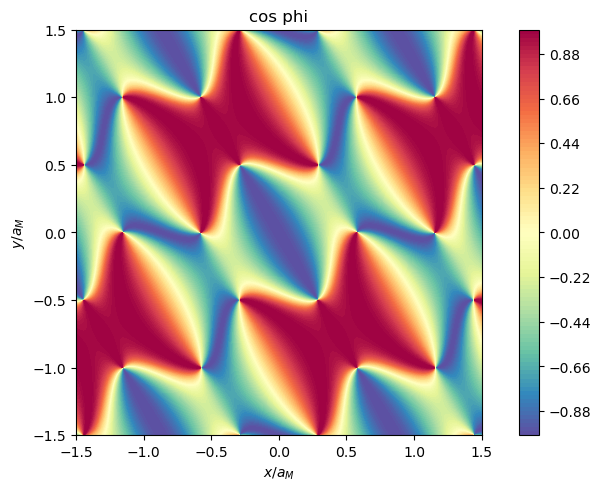

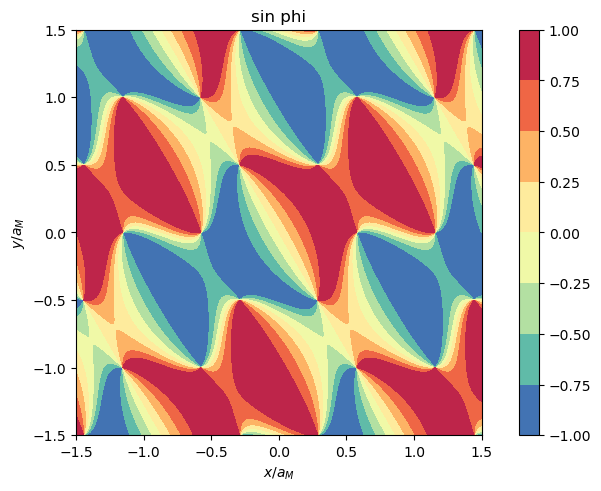

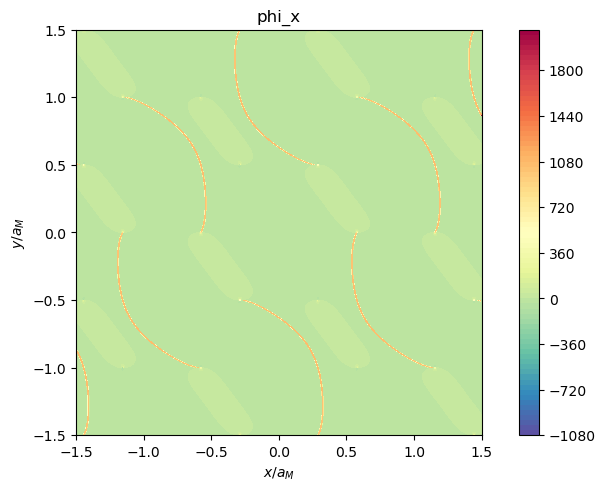

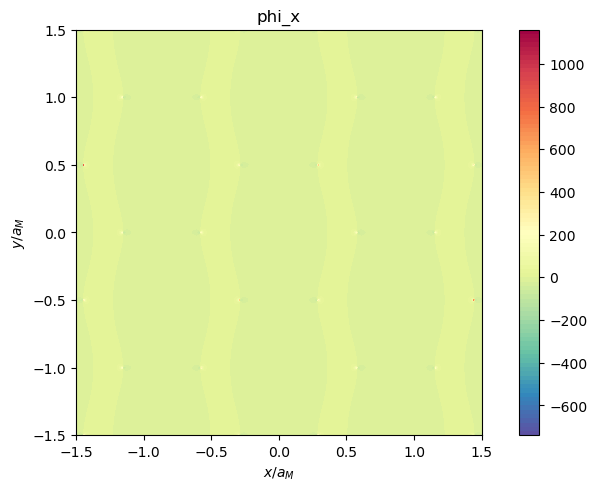

In [91]:
phi = bilayer.phi
phi_x, phi_y = np.gradient(phi, 2 * bilayer.xMax/(bilayer.N - 1), axis=(1,0))
cos_phi = bilayer.n[0] / np.sin(bilayer.theta)
sin_phi = bilayer.n[1] / np.sin(bilayer.theta)

phi_x2 = np.zeros((bilayer.N, bilayer.N))
phi_y2 = np.zeros((bilayer.N, bilayer.N))
sin_x, sin_y = np.gradient(sin_phi, 2 * bilayer.xMax/(bilayer.N - 1), axis=(1,0))
cos_x, cos_y = np.gradient(cos_phi, 2 * bilayer.xMax/(bilayer.N - 1), axis=(1,0))
for i in range(bilayer.N):
    for j in range(bilayer.N):
        if -0.1 < cos_phi[i,j] < 0.1:
            phi_x2[i,j] = cos_x[i,j] / (-sin_phi[i,j])
            phi_y2[i,j] = cos_y[i,j] / (-sin_phi[i,j])
        else:
            phi_x2[i,j] = sin_x[i,j] / (cos_phi[i,j])
            phi_y2[i,j] = sin_y[i,j] / (cos_phi[i,j])


fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('cos phi')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(bilayer.xx / bilayer.aM, bilayer.yy / bilayer.aM, cos_phi, 100, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()

fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('sin phi')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(bilayer.xx / bilayer.aM, bilayer.yy / bilayer.aM, sin_phi, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()

fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('phi_x')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(bilayer.xx / bilayer.aM, bilayer.yy / bilayer.aM, phi_x, 100, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()

fig, ax = plt.subplots(layout='constrained')

ax.set_aspect('equal')
ax.set_title('phi_x')
ax.set_xlabel('$x/a_M$')
ax.set_ylabel('$y/a_M$')
contours = ax.contourf(bilayer.xx / bilayer.aM, bilayer.yy / bilayer.aM, phi_y2, 100, cmap='Spectral_r')
cbar = fig.colorbar(contours)
plt.show()




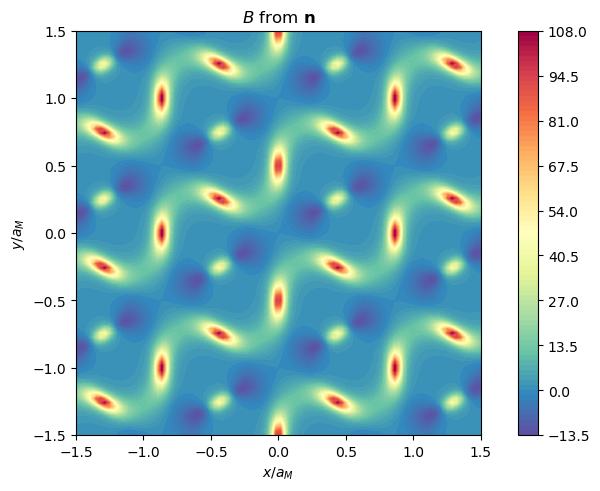

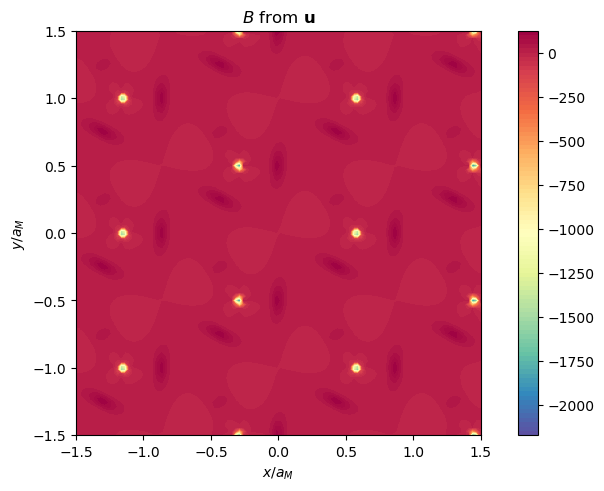

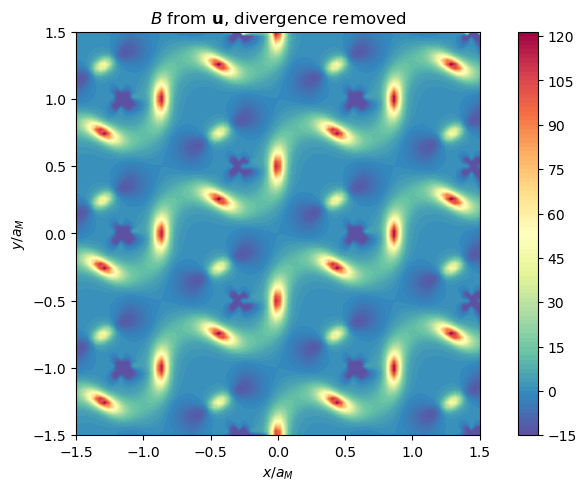

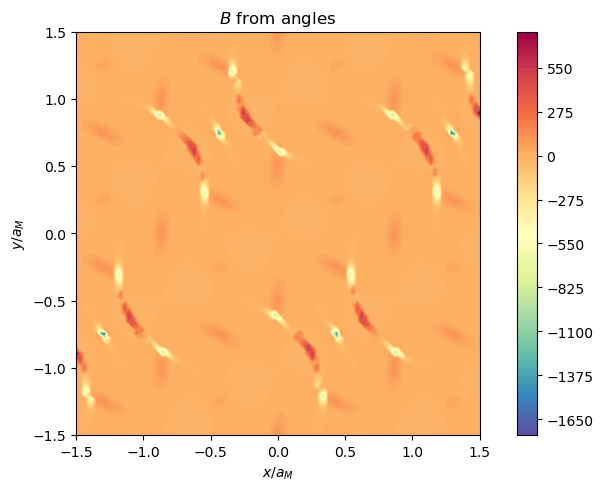

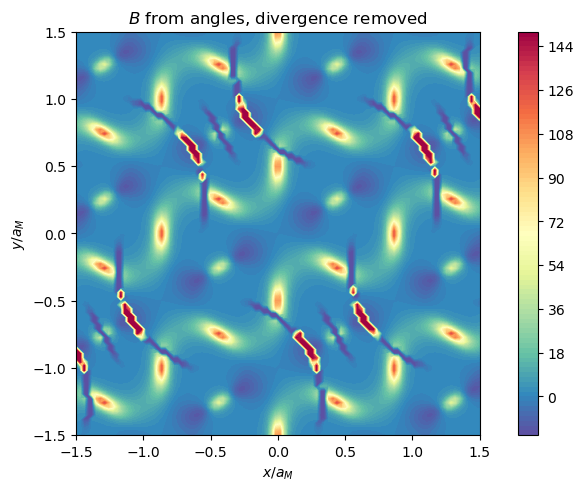

In [15]:
bilayer.plot('B', 100)
bilayer.plot('B2', 100)
bilayer.plot('B3', 100)
bilayer.plot('B4', 100)
bilayer.plot('B5', 100)


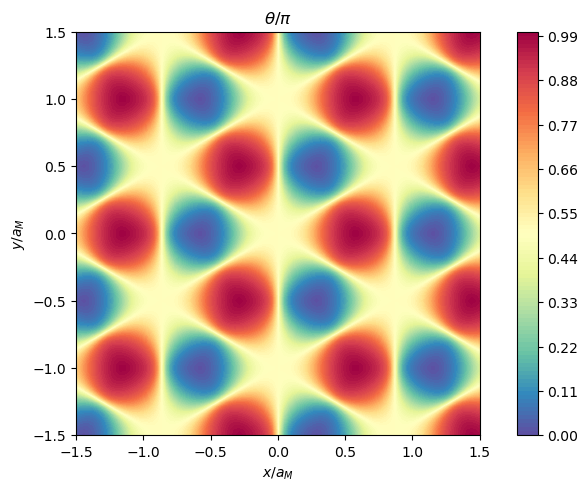

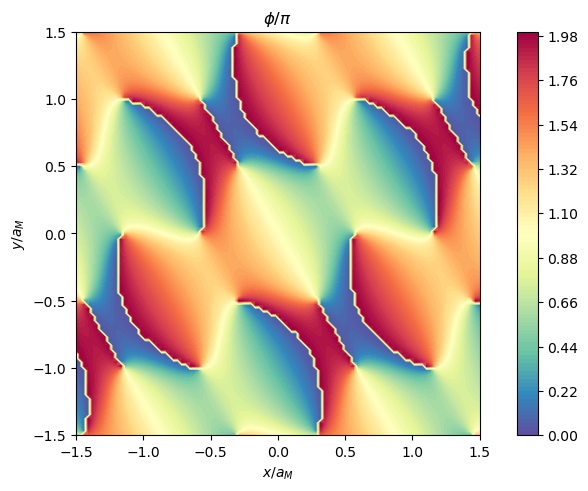

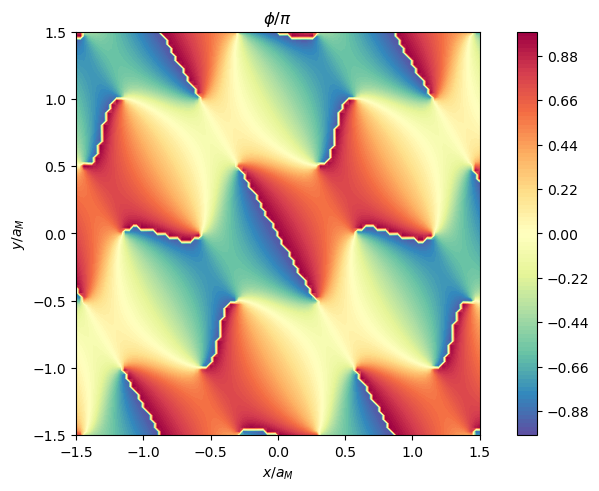

In [22]:
bilayer.plot('theta', 100)
bilayer.plot('phi', 100)
bilayer.plot('phi2', 100)

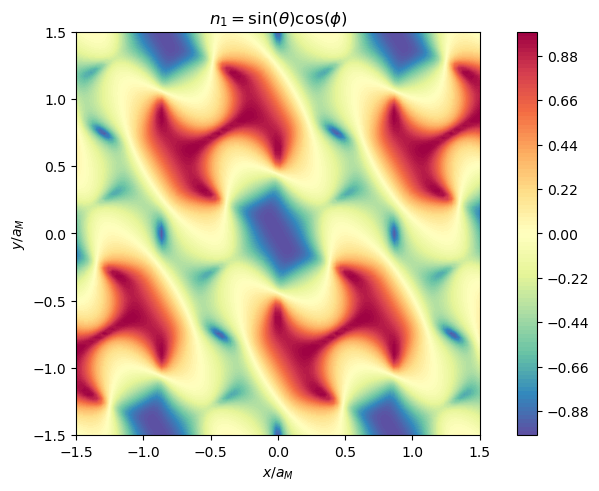

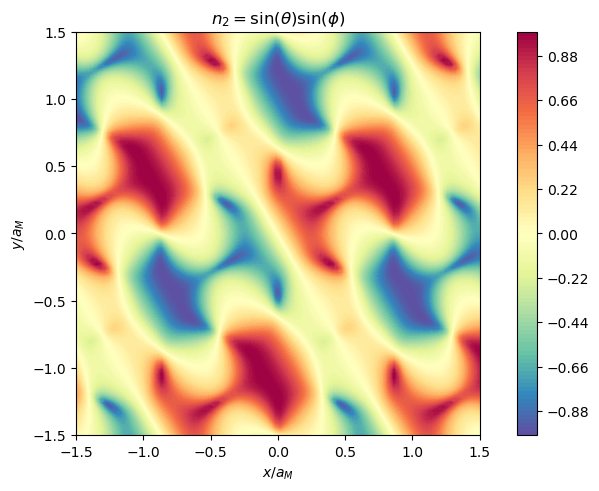

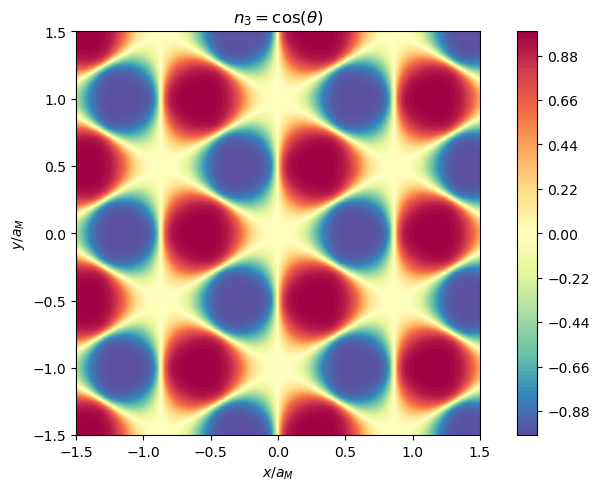

In [8]:
bilayer.plot('n[0]', 100)
bilayer.plot('n[1]', 100)
bilayer.plot('n[2]', 100)